## Data / Package Import 

In [1]:
import pandas as pd
import os
from Bio import Affy
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, GRU, Layer, Add, GlobalAveragePooling1D, Conv1D, ReLU
from sklearn.model_selection import KFold, cross_val_predict
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Dense, Dropout, Activation, LeakyReLU, Reshape
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, cross_val_score
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Lambda
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from hyperopt.pyll.base import scope
import scipy.stats as stats
from keras.layers import Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras import backend as K
from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from accelerate import DataLoaderConfiguration
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.regularizers import l1
from bayes_opt import BayesianOptimization
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from boruta import BorutaPy
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.linear_model import Lasso

C:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## AMGM and Cosine Feature Selection

In [2]:
def calculate_amgm(X):
    """
    Calculate AMGM for each feature (row) in the dataset X.
    
    Parameters:
    X (numpy array): The input data array with shape (n_features, n_samples)
    
    Returns:
    amgm_values (numpy array): The AMGM values for each feature (row)
    """
    N = X.shape[1]
    
    exp_X = np.exp(X)
    amgm_values = (np.mean(exp_X, axis=1)) / (np.exp(np.mean(X, axis=1)))
    
    return amgm_values

In [3]:
def filter_redundant_features(X, relevant_indices, threshold=0.9):
    relevant_features = X[relevant_indices, :]
    cos_sim_matrix = cosine_similarity(relevant_features)
    
    to_keep = []
    to_drop = set()
    for i in range(cos_sim_matrix.shape[0]):
        if i not in to_drop:
            to_keep.append(relevant_indices[i])
            for j in range(i + 1, cos_sim_matrix.shape[0]):
                if cos_sim_matrix[i, j] > threshold:
                    to_drop.add(relevant_indices[j])
    return to_keep

## Autoencoder Feature Selection with Lasso Regression

In [2]:
def create_feature_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)  # Encoder part
    decoded = Dense(input_dim, activation='sigmoid')(encoded)  # Decoder part
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    encoder = Model(inputs=input_layer, outputs=encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

In [3]:
def apply_l1_feature_selection(X, y, alpha=0.01, target_features=100):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    model = SelectFromModel(lasso, prefit=True, max_features=target_features)
    X_reduced = model.transform(X)
    selected_indices = model.get_support(indices=True)
    return X_reduced, selected_indices

## Initial Deep Autoencoder

In [62]:
def create_deep_autoencoder(input_dim):
    model = Sequential()
    model.add(Dense(input_dim // 2, input_shape=(input_dim,), activation='sigmoid'))
    model.add(Dropout(0.5))  # Add dropout layer
    model.add(Dense(input_dim // 4, activation='sigmoid'))
    model.add(Dropout(0.5))  # Add dropout layer
    model.add(Dense(input_dim // 2, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))  # Final classification layer
    return model

In [63]:
def cyclical_learning_rate(epoch, lr):
    base_lr = 0.001
    max_lr = 0.006
    step_size = 2000
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return lr

In [64]:
input_file_path = 'C:/Research_Summer/FinalizedAutismData.csv' #Change for different files

In [65]:
df = pd.read_csv(input_file_path, header=0, index_col=0)
features_df = df.iloc[:-1, :]  # SNP genotype data
case_control_info = df.iloc[-1, :]  # Case/Control row

C:\Users\colte\AppData\Local\Temp\ipykernel_32760\562430524.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255

In [66]:
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [83]:
X.shape

(225783, 567)

In [67]:
amgm_values = calculate_amgm(X)

In [68]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [69]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [181304  81445    990 223008   2500 164820  81208  97283  81289  56849]
Top AMGM values: [1.00451284 1.00451805 1.00451976 1.00452387 1.00452528 1.00452727
 1.00452986 1.00453206 1.00453611 1.00453671]


In [70]:
y = case_control_info.map({'Control': 0, 'Case': 1}).values

In [15]:
assert X.shape[1] == len(y), "Mismatch between number of samples in X and y"

In [71]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [72]:
X_selected = X[selected_indices, :].T 

In [73]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [74]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

In [75]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [76]:
y.shape

(567,)

In [89]:
input_dim = X_train.shape[1]
model = create_deep_autoencoder(input_dim)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [90]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 50)                5050      
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_31 (Dense)            (None, 25)                1275      
                                                                 
 dropout_5 (Dropout)         (None, 25)                0         
                                                                 
 dense_32 (Dense)            (None, 50)                1300      
                                                                 
 dense_33 (Dense)            (None, 100)               5100      
                                                                 
 dense_34 (Dense)            (None, 1)                

In [91]:
clr = LearningRateScheduler(cyclical_learning_rate)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[clr])

Epoch 1/50
13/13 [==============================] - 1s 13ms/step - loss: 0.6749 - accuracy: 0.5581 - val_loss: 0.6349 - val_accuracy: 0.6491 - lr: 0.0010
Epoch 2/50
13/13 [==============================] - 0s 5ms/step - loss: 0.7128 - accuracy: 0.5606 - val_loss: 0.6331 - val_accuracy: 0.6491 - lr: 0.0010
Epoch 3/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6689 - accuracy: 0.5960 - val_loss: 0.6398 - val_accuracy: 0.7018 - lr: 0.0010
Epoch 4/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6795 - accuracy: 0.5808 - val_loss: 0.6267 - val_accuracy: 0.6491 - lr: 0.0010
Epoch 5/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6762 - accuracy: 0.5909 - val_loss: 0.6256 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 6/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6674 - accuracy: 0.5732 - val_loss: 0.6145 - val_accuracy: 0.6842 - lr: 0.0010
Epoch 7/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6579 - 

In [92]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

4/4 [==============================] - 0s 6ms/step
Accuracy: 0.6491228070175439
F1 Score: 0.7333333333333335


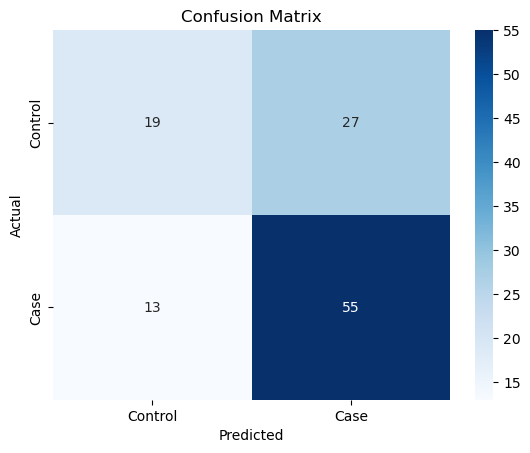

In [93]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'Case'], yticklabels=['Control', 'Case'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [94]:
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Specificity: {specificity}")
print(f"Sensitivity: {sensitivity}")

Accuracy: 0.6491228070175439
F1 Score: 0.7333333333333335
Specificity: 0.41304347826086957
Sensitivity: 0.8088235294117647


## Deep Autoencoder with Optimized Hyperparameters (Bayesian Optimization)

In [77]:
input_file_path = 'C:/Research_Summer/FinalizedAutismData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_5548\775459786.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,

In [78]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [ ]:
amgm_values = calculate_amgm(X)

In [ ]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [ ]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

In [ ]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [81]:
X_selected = X[selected_indices, :].T

In [83]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [84]:
def create_deep_autoencoder(input_dim, neurons1=64, neurons2=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons1, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons1, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))  # Final classification layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [85]:
space = {
    'neurons1': scope.int(hp.quniform('neurons1', 32, 256, 32)),
    'neurons2': scope.int(hp.quniform('neurons2', 16, 128, 16)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'epochs': scope.int(hp.quniform('epochs', 50, 200, 50)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [86]:
def objective(params):
    model = KerasClassifier(
        model=create_deep_autoencoder,
        input_dim=X_selected.shape[1],
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_selected, y, cv=kfold, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)  # True Positive Rate / Recall
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Sensitivity: {sensitivity}, Specificity: {specificity}")

    # Return the negative F1 score as Hyperopt minimizes the objective function
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy, 'f1': f1, 'sensitivity': sensitivity, 'specificity': specificity}

In [90]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of evaluations to perform
            trials=trials)

print("Best parameters found: ", best)

Accuracy: 0.6419753086419753, F1 Score: 0.7353324641460235, Sensitivity: 0.8417910447761194, Specificity: 0.35344827586206895
Accuracy: 0.6860670194003528, F1 Score: 0.7541436464088398, Sensitivity: 0.8149253731343283, Specificity: 0.5          
Accuracy: 0.6049382716049383, F1 Score: 0.7206982543640897, Sensitivity: 0.8626865671641791, Specificity: 0.23275862068965517
Accuracy: 0.5908289241622575, F1 Score: 0.7427937915742794, Sensitivity: 1.0, Specificity: 0.0                         
Accuracy: 0.6860670194003528, F1 Score: 0.7541436464088398, Sensitivity: 0.8149253731343283, Specificity: 0.5          
Accuracy: 0.6225749559082893, F1 Score: 0.7131367292225201, Sensitivity: 0.7940298507462686, Specificity: 0.375        
Accuracy: 0.5661375661375662, F1 Score: 0.60828025477707, Sensitivity: 0.5701492537313433, Specificity: 0.5603448275862069
Accuracy: 0.582010582010582, F1 Score: 0.6570188133140377, Sensitivity: 0.6776119402985075, Specificity: 0.44396551724137934
Accuracy: 0.65255731

In [93]:
best_trial = min(trials.results, key=lambda x: x['loss'])
print(f"Best Accuracy: {best_trial['accuracy']}")
print(f"Best F1 Score: {-best_trial['loss']}")
print(f"Best Specificity: {best_trial['specificity']}")
print(f"Best Sensitivity: {best_trial['sensitivity']}")

Best Accuracy: 0.6878306878306878
Best F1 Score: 0.7604871447902571
Best Specificity: 0.4698275862068966
Best Sensitivity: 0.8388059701492537


In [97]:
best_params = {
    'neurons1': int(best['neurons1']),
    'neurons2': int(best['neurons2']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

best_model = create_deep_autoencoder(
    input_dim=X_selected.shape[1],
    neurons1=best_params['neurons1'],
    neurons2=best_params['neurons2'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model.summary()

Model: "sequential_4991"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16855 (Dense)                  │ (None, 96)                  │           9,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6742 (Dropout)               │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16856 (Dense)                  │ (None, 64)                  │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6743 (Dropout)               │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16857 (Dense)                  │ (None, 96)                  │           6,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16858 (Dense)                  │ (None, 100)                 │           9,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16859 (Dense)                  │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,945 (124.79 KB)

 Trainable params: 31,945 (124.79 KB)

 Non-trainable params: 0 (0.00 B)

In [98]:
print("\nBest Hyperparameters:")
print(f"Neurons in first layer: {int(best['neurons1'])}")
print(f"Neurons in second layer: {int(best['neurons2'])}")
print(f"Dropout rate: {best['dropout_rate']}")
print(f"Learning rate: {best['learning_rate']}")
print(f"Number of epochs: {int(best['epochs'])}")
print(f"Batch size: {int(best['batch_size'])}")


Best Hyperparameters:
Neurons in first layer: 96
Neurons in second layer: 64
Dropout rate: 0.6148142319059324
Learning rate: 0.00014614352648276044
Number of epochs: 100
Batch size: 112


## Bidirectional LSTM with Bayesian Optimization

In [114]:
def create_rnn_model(input_shape, units=64, bidirectional=False, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    if bidirectional:
        model.add(Bidirectional(LSTM(units, return_sequences=False)))
    else:
        model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [115]:
Input_file_path = 'C:/Research_Summer/FinalizedAutismData.csv'  # Change for different files
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_5548\2897354534.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255

In [116]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values 
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [117]:
amgm_values = calculate_amgm(X)

In [118]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [119]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [181304  81445    990 223008   2500 164820  81208  97283  81289  56849]
Top AMGM values: [1.00451284 1.00451805 1.00451976 1.00452387 1.00452528 1.00452727
 1.00452986 1.00453206 1.00453611 1.00453671]


In [120]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [121]:
X_selected = X[selected_indices, :].T

In [122]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [123]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

In [124]:
space = {
    'units': scope.int(hp.quniform('units', 32, 128, 32)),  # Reduced range for faster evaluation
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),  # Reduced range
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),  # Adjusted range
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),  # Reduced number of epochs
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16)),  # Reduced range
    'bidirectional': hp.choice('bidirectional', [True, False])
}

In [125]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)  
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = KerasClassifier(
            model=create_rnn_model,
            input_shape=(X_selected.shape[1], 1),
            units=params['units'],
            bidirectional=params['bidirectional'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=0
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred = model.predict(X_val)
        
        # Convert predictions to binary using a threshold of 0.5
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)  # True Positive Rate / Recall
        specificity = tn / (tn + fp)  # True Negative Rate

        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [126]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials
            trials=trials)

Iteration Results - Accuracy: 0.6909492273730685, F1 Score: 0.7628242789403069, Sensitivity: 0.8427705622844007, Specificity: 0.4708601011481684
Iteration Results - Accuracy: 0.6865342163355409, F1 Score: 0.7540730023988846, Sensitivity: 0.8165392958951236, Specificity: 0.4969017678148351
Iteration Results - Accuracy: 0.6887417218543046, F1 Score: 0.7564035938599108, Sensitivity: 0.8203707135196447, Specificity: 0.4969017678148351
Iteration Results - Accuracy: 0.6887417218543046, F1 Score: 0.7564035938599108, Sensitivity: 0.8203707135196447, Specificity: 0.4969017678148351
Iteration Results - Accuracy: 0.6799116997792494, F1 Score: 0.7558187491520826, Sensitivity: 0.8428065929582025, Specificity: 0.4436423592126845
Iteration Results - Accuracy: 0.6865342163355409, F1 Score: 0.7540730023988846, Sensitivity: 0.8165392958951236, Specificity: 0.4969017678148351
Iteration Results - Accuracy: 0.6865342163355409, F1 Score: 0.7551305620341152, Sensitivity: 0.8203707135196447, Specificity: 0.49

In [127]:
best_params = {
    'units': int(best['units']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size']),
    'bidirectional': best['bidirectional']
}

print("Best Hyperparameters:", best_params)

# Build and summarize the best model
best_model = create_rnn_model(
    input_shape=(X_selected.shape[1], 1),
    units=best_params['units'],
    bidirectional=best_params['bidirectional'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])


Best Hyperparameters: {'units': 32, 'dropout_rate': 0.2273582314066485, 'learning_rate': 0.0020901109616035933, 'epochs': 50, 'batch_size': 32, 'bidirectional': 0}


In [128]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Test Performance:
Accuracy: 0.6666666666666666
F1 Score: 0.7432432432432432
Sensitivity: 0.8208955223880597
Specificity: 0.44680851063829785


## Gru with Bayesian Optimization

In [132]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [146]:
def create_gru_model(input_shape, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [135]:
input_file_path = 'C:/Research_Summer/FinalizedAutismData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_5548\775459786.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,

In [136]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [137]:
amgm_values = calculate_amgm(X)

In [138]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [139]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [140]:
X_selected = X[selected_indices, :].T

In [141]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [148]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [147]:
space = {
    'units': scope.int(hp.quniform('units', 32, 64, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.4),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 20, 30, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [149]:
def objective(params):
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]
        
        model = KerasClassifier(
            model=create_gru_model,
            input_shape=(X_selected.shape[1], 1),
            units=params['units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=0
        )
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        
        model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])
        
        y_val_pred = model.predict(X_val)
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)
    
    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")
    
    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [152]:
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

Iteration Results - Accuracy: 0.6909492273730683, F1 Score: 0.758163023554497, Sensitivity: 0.824890336001447, Specificity: 0.5015873015873016
Iteration Results - Accuracy: 0.6953642384105961, F1 Score: 0.7659594656157523, Sensitivity: 0.8483687852108904, Specificity: 0.48134920634920636
 10%|████▌                                        | 2/20 [15:42<2:33:03, 510.20s/trial, best loss: -0.7659594656157523]ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\ProgramData\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\rnn.py", line 418, in <genexpr>
    output_ta_t = tuple(  File "C:\ProgramData\anaconda3\Lib\site-packages\tensorflow\python\util\tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
Iteration Results - Accuracy: 0.6953642384105961,

In [154]:
best_params = space_eval(space, best)
print("Best Parameters:", best_params)

Best Parameters: {'batch_size': 32, 'dropout_rate': 0.35324918507868847, 'epochs': 30, 'learning_rate': 0.0001111270432741828, 'units': 64}


In [155]:
best_model = create_gru_model(
    input_shape=(X_selected.shape[1], 1),
    units=best_params['units'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

In [156]:
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [157]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

In [160]:
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step

Test Performance:
Accuracy: 0.631578947368421
F1 Score: 0.7307692307692307
Sensitivity: 0.8382352941176471
Specificity: 0.32608695652173914


## CNN with Bayesian Optimization

In [162]:
input_file_path = 'C:/Research_Summer/FinalizedAutismData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_5548\775459786.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,

In [163]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [164]:
amgm_values = calculate_amgm(X)

In [165]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [166]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [167]:
X_selected = X[selected_indices, :].T

In [168]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [169]:
X_selected = X_selected.reshape(X_selected.shape[0], X_selected.shape[1], 1)  # Add a channel dimension

In [170]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [171]:
def create_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [172]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 2, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [173]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = create_cnn_model(
            input_shape=(X_selected.shape[1], 1),
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred = model.predict(X_val)
        
        # Convert predictions to binary using a threshold of 0.5
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [174]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials, adjust based on your needs
            trials=trials)

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step                                                
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step                                                
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step                                                
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step                                                

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step                                                
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step                                                
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step                                                

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step                                                
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step                                                
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step                                                

Iteration Results - Accuracy: 0.6710816777041942, F1 Score: 0.7583674703021863, Sensitivity: 0.8801576591050275, Specificity: 0.354761904

In [175]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 64, 'dropout_rate': 0.3265716784635214, 'epochs': 40, 'filters': 64, 'kernel_size': 2, 'learning_rate': 0.0016533772254117716}


In [176]:
best_model = create_cnn_model(
    input_shape=(X_selected.shape[1], 1),
    filters=best_params['filters'],
    kernel_size=best_params['kernel_size'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

In [180]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

In [181]:
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [182]:
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")


Test Performance:
Accuracy: 0.631578947368421
F1 Score: 0.6818181818181818
Sensitivity: 0.6617647058823529
Specificity: 0.5869565217391305


## ResNet

In [186]:
input_file_path = 'C:/Research_Summer/FinalizedAutismData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_5548\775459786.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,

In [187]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [188]:
amgm_values = calculate_amgm(X)

In [189]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [190]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [191]:
X_selected = X[selected_indices, :].T

In [192]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [193]:
X_selected = X_selected.reshape((X_selected.shape[0], X_selected.shape[1], 1))

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [195]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same', strides=stride)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, kernel_size, padding='same', strides=1)(x)
    x = BatchNormalization()(x)
    
    if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv1D(filters, kernel_size, padding='same', strides=stride)(shortcut)
        shortcut = BatchNormalization()(shortcut)
        
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

In [196]:
def create_resnet_model(input_shape, filters=64, num_blocks=6, kernel_size=3, dropout_rate=0.5, learning_rate=0.001):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters, kernel_size=kernel_size, padding='same', strides=1)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    for _ in range(num_blocks):
        x = residual_block(x, filters, kernel_size=kernel_size)
    
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [197]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'num_blocks': scope.int(hp.quniform('num_blocks', 4, 10, 2)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 3, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16)),
    'epochs': scope.int(hp.quniform('epochs', 20, 50, 10))
}

In [198]:
def objective(params):
    print(f"Trying params: {params}")
    filters = params['filters']
    num_blocks = params['num_blocks']
    kernel_size = params['kernel_size']
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']
    
    # Create the ResNet model
    model = create_resnet_model(input_shape=(X_train.shape[1], 1),
                                filters=filters,
                                num_blocks=num_blocks,
                                kernel_size=kernel_size,
                                dropout_rate=dropout_rate,
                                learning_rate=learning_rate)
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Filters: {filters}, Blocks: {num_blocks}, Kernel Size: {kernel_size}, Dropout: {dropout_rate}, LR: {learning_rate}, Batch Size: {batch_size}, Epochs: {epochs}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [199]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Adjust the number of evaluations
            trials=trials)

Trying params: {'batch_size': 48, 'dropout_rate': 0.2554784021852648, 'epochs': 40, 'filters': 32, 'kernel_size': 5, 'learning_rate': 0.008343218461711608, 'num_blocks': 10}
Iteration - Loss: 5.613563060760498, Filters: 32, Blocks: 10, Kernel Size: 5, Dropout: 0.2554784021852648, LR: 0.008343218461711608, Batch Size: 48, Epochs: 40
Trying params: {'batch_size': 64, 'dropout_rate': 0.45846293468049965, 'epochs': 30, 'filters': 96, 'kernel_size': 5, 'learning_rate': 0.0004150790051000427, 'num_blocks': 6}
Iteration - Loss: 0.6343879103660583, Filters: 96, Blocks: 6, Kernel Size: 5, Dropout: 0.45846293468049965, LR: 0.0004150790051000427, Batch Size: 64, Epochs: 30
Trying params: {'batch_size': 32, 'dropout_rate': 0.43757619387353786, 'epochs': 20, 'filters': 96, 'kernel_size': 5, 'learning_rate': 0.00014456351369973832, 'num_blocks': 10}
Iteration - Loss: 0.6912713050842285, Filters: 96, Blocks: 10, Kernel Size: 5, Dropout: 0.43757619387353786, LR: 0.00014456351369973832, Batch Size: 32,

In [200]:
best_params = space_eval(space, best)
print(f"Best parameters: {best_params}")

Best parameters: {'batch_size': 16, 'dropout_rate': 0.46505543821988665, 'epochs': 30, 'filters': 64, 'kernel_size': 3, 'learning_rate': 0.0063597097406487306, 'num_blocks': 6}


In [201]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
best_model = create_resnet_model(input_shape=(X_train.shape[1], 1),
                                 filters=best_params['filters'],
                                 num_blocks=best_params['num_blocks'],
                                 kernel_size=best_params['kernel_size'],
                                 dropout_rate=best_params['dropout_rate'],
                                 learning_rate=best_params['learning_rate'])

In [202]:
history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_split=0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 281ms/step - accuracy: 0.6073 - loss: 1.1508 - val_accuracy: 0.6304 - val_loss: 67.9615
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 285ms/step - accuracy: 0.6199 - loss: 0.7936 - val_accuracy: 0.6522 - val_loss: 0.6406
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 285ms/step - accuracy: 0.5918 - loss: 0.8870 - val_accuracy: 0.6304 - val_loss: 0.9727
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.6580 - loss: 0.6551 - val_accuracy: 0.5652 - val_loss: 1.0798
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - accuracy: 0.6905 - loss: 0.6527 - val_accuracy: 0.3696 - val_loss: 1.0649


In [203]:
y_test_pred = (best_model.predict(X_test) > 0.5).astype("int32")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


In [204]:
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")


Test Performance:
Accuracy: 0.5964912280701754
F1 Score: 0.7160493827160493
Sensitivity: 0.8529411764705882
Specificity: 0.21739130434782608


## FNN with Bayesian Optimization

In [205]:
input_file_path = 'C:/Research_Summer/FinalizedAutismData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_5548\775459786.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,

In [206]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [207]:
amgm_values = calculate_amgm(X)

In [208]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [209]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [210]:
X_selected = X[selected_indices, :].T

In [211]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [212]:
X_selected = X_selected.reshape((X_selected.shape[0], X_selected.shape[1], 1))

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [214]:
def create_fnn_model(input_dim, num_layers=2, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    
    for _ in range(num_layers - 1):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [215]:
space = {
    'num_layers': scope.int(hp.quniform('num_layers', 2, 6, 1)),
    'units': scope.int(hp.quniform('units', 64, 256, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 50, 150, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [216]:
def objective(params):
    # Create the FNN model with given hyperparameters
    model = create_fnn_model(input_dim=X_train.shape[1], 
                             num_layers=params['num_layers'], 
                             units=params['units'], 
                             dropout_rate=params['dropout_rate'], 
                             learning_rate=params['learning_rate'])
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Params: {params}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [217]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,  # Number of evaluations (trials)
            trials=trials)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Iteration - Loss: 0.5187875628471375, Params: {'batch_size': 16, 'dropout_rate': 0.28050824233459554, 'epochs': 70, 'learning_rate': 0.0005462451227884165, 'num_layers': 6, 'units': 160}
Iteration - Loss: 0.5185142755508423, Params: {'batch_size': 64, 'dropout_rate': 0.1765393185080557, 'epochs': 60, 'learning_rate': 0.0006576944812491112, 'num_layers': 5, 'units': 160}
Iteration - Loss: 0.5312281250953674, Params: {'batch_size': 80, 'dropout_rate': 0.22316120047432159, 'epochs': 150, 'learning_rate': 7.740840564807408e-05, 'num_layers': 4, 'units': 128}
Iteration - Loss: 0.48945751786231995, Params: {'batch_size': 80, 'dropout_rate': 0.12190184387760548, 'epochs': 80, 'learning_rate': 1.4030871665251051e-05, 'num_layers': 3, 'units': 160}
Iteration - Loss: 0.5439595580101013, Params: {'batch_size': 48, 'dropout_rate': 0.3679344541119146, 'epochs': 90, 'learning_rate': 0.002480791127927536, 'num_layers': 5, 'units': 64}
Iteration - Loss: 0.5856583714485168, Params: {'batch_size': 80, '

In [218]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 80, 'dropout_rate': 0.12190184387760548, 'epochs': 80, 'learning_rate': 1.4030871665251051e-05, 'num_layers': 3, 'units': 160}


In [221]:
best_model = create_fnn_model(input_dim=X_train.shape[1],
                              num_layers=best_params['num_layers'],
                              units=best_params['units'],
                              dropout_rate=best_params['dropout_rate'],
                              learning_rate=best_params['learning_rate'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], 
                         validation_split=0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/80


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4275 - loss: 0.7481 - val_accuracy: 0.4348 - val_loss: 0.7205
Epoch 2/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4134 - loss: 0.7509 - val_accuracy: 0.4130 - val_loss: 0.7142
Epoch 3/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4950 - loss: 0.7258 - val_accuracy: 0.4565 - val_loss: 0.7083
Epoch 4/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4539 - loss: 0.7378 - val_accuracy: 0.5000 - val_loss: 0.7022
Epoch 5/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4623 - loss: 0.7273 - val_accuracy: 0.5652 - val_loss: 0.6969
Epoch 6/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4825 - loss: 0.7208 - val_accuracy: 0.5652 - val_loss: 0.6918
Epoch 7/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5324 - loss: 0.7081 - val_accuracy: 0.5652 - val_loss: 0.6871
Epoch 8/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4969 - loss: 0.7189 - val_accuracy: 0.5870 - val_loss: 0.6821
Epoch 9/80


In [222]:
y_test_pred = (best_model.predict(X_test) > 0.5).astype("int32")

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Test Performance:
Accuracy: 0.631578947368421
F1 Score: 0.7236842105263158
Sensitivity: 0.8088235294117647
Specificity: 0.3695652173913043


## BERT Transformer

In [6]:
input_file_path = 'C:/Research_Summer/FinalizedAutismData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_1428\775459786.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,

In [26]:
features_df = df.iloc[:-1, :]
case_control_info = df.iloc[-1, :]
labels = case_control_info.map({'Control': 0, 'Case': 1}).values
features_df = features_df.apply(pd.to_numeric, errors='coerce').fillna(0)

In [27]:
amgm_values = calculate_amgm(features_df.values)
num_features = 10000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [28]:
selected_indices = filter_redundant_features(features_df.values, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:1000]

In [29]:
X_selected = features_df.iloc[selected_indices, :].T
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [30]:
sequences = [' '.join(map(str, row)) for row in X_selected]

In [31]:
class SNPDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [32]:
def objective(trial):
    # Suggest hyperparameters
    num_train_epochs = trial.suggest_int('num_train_epochs', 2, 3)  # Reduced number of epochs for faster trials
    batch_size = trial.suggest_categorical('batch_size', [16, 32])  # Higher batch sizes might not fit in memory
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
    max_length = trial.suggest_int('max_length', 128, 256)  # Reduced sequence length

    # Load DistilBERT tokenizer and model
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

    # Split the data
    train_texts, val_texts, train_labels, val_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42)

    # Tokenize the data
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=max_length)

    # Create PyTorch Datasets
    train_dataset = SNPDataset(train_encodings, train_labels)
    val_dataset = SNPDataset(val_encodings, val_labels)

    # Define TrainingArguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        save_strategy="epoch",
        save_total_limit=1  # Keep only the last checkpoint
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_result = trainer.evaluate(eval_dataset=val_dataset)

    # Return the evaluation metric to be minimized
    return eval_result['eval_loss']

In [33]:
study = optuna.create_study(direction='minimize')

[I 2024-06-12 13:15:05,959] A new study created in memory with name: no-name-f658c1d2-fad1-4c3c-b2c3-e964e60ea6ad


In [34]:
study.optimize(objective, n_trials=5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.684700,0.672502
2,0.677000,0.679910
3,0.686500,0.667740


[I 2024-06-12 13:24:56,663] Trial 0 finished with value: 0.6677395105361938 and parameters: {'num_train_epochs': 3, 'batch_size': 16, 'learning_rate': 1.6829711833684297e-05, 'max_length': 238}. Best is trial 0 with value: 0.6677395105361938.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.689000,0.677743
2,0.669800,0.705634
3,0.692000,0.675662


[I 2024-06-12 13:32:12,140] Trial 1 finished with value: 0.6756619811058044 and parameters: {'num_train_epochs': 3, 'batch_size': 16, 'learning_rate': 2.9065545374840432e-05, 'max_length': 173}. Best is trial 0 with value: 0.6677395105361938.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.693800,0.672848
2,0.672200,0.688792


[I 2024-06-12 13:38:10,936] Trial 2 finished with value: 0.6887920498847961 and parameters: {'num_train_epochs': 2, 'batch_size': 16, 'learning_rate': 1.5860725722731893e-05, 'max_length': 202}. Best is trial 0 with value: 0.6677395105361938.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.683500,0.673506
2,0.675000,0.669618
3,0.667500,0.680385


[I 2024-06-12 13:48:47,696] Trial 3 finished with value: 0.680384635925293 and parameters: {'num_train_epochs': 3, 'batch_size': 32, 'learning_rate': 3.419802991177643e-05, 'max_length': 227}. Best is trial 0 with value: 0.6677395105361938.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.684100,0.676915
2,0.675700,0.672363
3,0.671900,0.670186


[I 2024-06-12 13:59:53,849] Trial 4 finished with value: 0.6701861619949341 and parameters: {'num_train_epochs': 3, 'batch_size': 32, 'learning_rate': 1.7363901182178265e-05, 'max_length': 232}. Best is trial 0 with value: 0.6677395105361938.


In [35]:
print("Best hyperparameters: ", study.best_params)

Best hyperparameters:  {'num_train_epochs': 3, 'batch_size': 16, 'learning_rate': 1.6829711833684297e-05, 'max_length': 238}


In [36]:
best_params = study.best_params

In [37]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
train_texts, val_texts, train_labels, val_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
train_dataset = SNPDataset(train_encodings, train_labels)
val_dataset = SNPDataset(val_encodings, val_labels)

In [39]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=best_params['num_train_epochs'],
    per_device_train_batch_size=best_params['batch_size'],
    per_device_eval_batch_size=best_params['batch_size'],
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    learning_rate=best_params['learning_rate']
)

In [40]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


In [41]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.701800,0.672019
2,0.689400,0.667910
3,0.711100,0.668611


TrainOutput(global_step=87, training_loss=0.6809920168471062, metrics={'train_runtime': 2996.3643, 'train_samples_per_second': 0.454, 'train_steps_per_second': 0.029, 'total_flos': 357567924234240.0, 'train_loss': 0.6809920168471062, 'epoch': 3.0})

In [42]:
predictions, labels, _ = trainer.predict(val_dataset)
preds = np.argmax(predictions, axis=1)

# Calculate metrics
accuracy = accuracy_score(val_labels, preds)
f1 = f1_score(val_labels, preds)
conf_matrix = confusion_matrix(val_labels, preds)

# Compute specificity and sensitivity
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Accuracy: 0.5964912280701754
F1 Score: 0.7472527472527473
Sensitivity: 1.0
Specificity: 0.0


## Sparse Autoencoder

In [4]:
input_file_path = 'C:/Research_Summer/FinalizedAutismData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_16172\775459786.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255

In [5]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values
X = X.T

In [6]:
amgm_values = calculate_amgm(X)

In [7]:
num_features = 25000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [8]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:2500] 

In [9]:
X_selected = X[:, selected_indices]

In [10]:
scaler = StandardScaler()
X = scaler.fit_transform(X_selected)
X_train, X_val, y_train, y_val= train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [11]:
def create_sparse_autoencoder(input_dim, num_units, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(num_units, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer))(input_layer)
    encoder = Dropout(dropout_rate)(encoder)
    decoder = Dense(input_dim, activation='sigmoid')(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    return autoencoder

In [12]:
def objective(trial):
    # Hyperparameters to tune
    num_units = trial.suggest_int('num_units', 64, 256)  # Reduced upper bound
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)  # Lower upper bound
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.3)  # Reduced upper bound
    activity_regularizer = trial.suggest_float('activity_regularizer', 1e-7, 1e-4, log=True)  # Reduced range
    batch_size = trial.suggest_int('batch_size', 16, 64)  # Reduced upper bound

    # Create the model
    model = create_sparse_autoencoder(input_dim=X_train.shape[1], num_units=num_units, dropout_rate=dropout_rate, activity_regularizer=activity_regularizer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())

    # Set early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, X_train, epochs=50, batch_size=batch_size, validation_data=(X_val, X_val), callbacks=[early_stopping, TFKerasPruningCallback(trial, 'val_loss')], verbose=0)

    # Return the best validation loss
    val_loss = min(history.history['val_loss'])
    return val_loss

In [13]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-06-13 08:41:28,955] A new study created in memory with name: no-name-1a5e3eb6-6b13-4691-8bb4-bef90ebbe5b3
[I 2024-06-13 08:41:33,975] Trial 0 finished with value: 0.0015418485272675753 and parameters: {'num_units': 208, 'learning_rate': 2.6880391952782476e-05, 'dropout_rate': 0.14453370803496787, 'activity_regularizer': 1.0911381569660001e-07, 'batch_size': 60}. Best is trial 0 with value: 0.0015418485272675753.
[I 2024-06-13 08:41:38,222] Trial 1 finished with value: 0.0003254197654314339 and parameters: {'num_units': 78, 'learning_rate': 0.0002760389535657363, 'dropout_rate': 0.008229570688697318, 'activity_regularizer': 3.357830757088946e-07, 'batch_size': 29}. Best is trial 1 with value: 0.0003254197654314339.
[I 2024-06-13 08:41:42,926] Trial 2 finished with value: 0.0003185069072060287 and parameters: {'num_units': 103, 'learning_rate': 5.104575537820124e-05, 'dropout_rate': 0.17612624894541537, 'activity_regularizer': 3.2645465097138066e-07, 'batch_size': 25}. Best is tr

In [14]:
best_params = study.best_params
print("Best Hyperparameters: ", best_params)

Best Hyperparameters:  {'num_units': 172, 'learning_rate': 0.000897573470293013, 'dropout_rate': 0.05483276230765702, 'activity_regularizer': 1.3527213139935319e-07, 'batch_size': 20}


In [15]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [34]:
best_model = create_sparse_autoencoder(input_dim=X_train.shape[1], num_units=best_params['num_units'], dropout_rate=best_params['dropout_rate'], activity_regularizer=best_params['activity_regularizer'])
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss=MeanSquaredError())
best_model.fit(X_train, X_train, epochs=50, batch_size=best_params['batch_size'], validation_data=(X_val, X_val), callbacks=[early_stopping], verbose=1)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0022 - val_loss: 4.4884e-04
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3785e-04 - val_loss: 3.0633e-04
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3508e-04 - val_loss: 3.0055e-04
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2121e-04 - val_loss: 2.9912e-04
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2251e-04 - val_loss: 2.9469e-04


In [35]:
val_loss = best_model.evaluate(X_val, X_val)
print("Validation Loss: ", val_loss)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6947e-04 
Validation Loss:  0.00045960501302033663


In [36]:
reconstructions = best_model.predict(X_val)
reconstruction_errors = np.mean(np.square(X_val - reconstructions), axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [37]:
threshold = np.percentile(reconstruction_errors, 95)
y_pred = (reconstruction_errors > threshold).astype(int)

In [38]:
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

In [39]:
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Accuracy: 0.40350877192982454
F1 Score: 0.0
Sensitivity: 0.0
Specificity: 1.0


## Stacked Autoencoder & LSTM Model

In [24]:
Input_file_path = 'C:/Research_Summer/FinalizedAutismData.csv'  # Change for different files
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_23480\1299816614.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,25

In [25]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values 
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [26]:
X = X.astype('float32')
y = y.astype('float32')

In [27]:
amgm_values = calculate_amgm(X)

In [28]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [29]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [108788  46654  90362  87579    126 155109 152481  70311 158481  79797]
Top AMGM values: [1.0023952 1.0023955 1.0023957 1.0023957 1.0023966 1.0023972 1.0023975
 1.0023975 1.0023979 1.0023985]


In [30]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [31]:
X_selected = X[selected_indices, :].T
X_selected = X_selected.astype('float32')

In [32]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected).astype('float32')

In [33]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [34]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [35]:
def create_bilstm_model(input_shape, lstm_units, dropout_rate, output_dim):
    inputs = Input(shape=(input_shape[1], input_shape[2]), dtype='float32')
    x = Bidirectional(LSTM(lstm_units, return_sequences=True, dtype='float32'))(inputs)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(lstm_units, dtype='float32'))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(output_dim, activation='sigmoid', dtype='float32')(x)
    model = Model(inputs, outputs)
    return model

In [36]:
def create_stacked_model(X_train, X_val, autoencoder_params, lstm_params):
    input_dim = X_train.shape[1]
    
    # Autoencoder part
    autoencoder, encoder = create_deep_autoencoder(
        input_dim=input_dim,
        encoding_dim=autoencoder_params['encoding_dim'],
        hidden_layers=autoencoder_params['hidden_layers'],
        dropout_rate=autoencoder_params['dropout_rate'],
        activity_regularizer=autoencoder_params['activity_regularizer']
    )
    autoencoder.compile(optimizer=Adam(learning_rate=autoencoder_params['learning_rate']), loss='mse')
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=autoencoder_params['batch_size'], validation_data=(X_val, X_val), verbose=0)

    # Encoder output
    X_encoded_train = encoder.predict(X_train).astype('float32')
    X_encoded_val = encoder.predict(X_val).astype('float32')
    
    # Prepare for LSTM
    X_encoded_train = np.expand_dims(X_encoded_train, axis=-1)
    X_encoded_val = np.expand_dims(X_encoded_val, axis=-1)

    # BiLSTM part
    lstm_model = create_bilstm_model(input_shape=X_encoded_train.shape, lstm_units=lstm_params['lstm_units'], dropout_rate=lstm_params['dropout_rate'], output_dim=1)
    lstm_model.compile(optimizer=Adam(learning_rate=lstm_params['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])

    return autoencoder, lstm_model, X_encoded_train, X_encoded_val

In [37]:
def objective(params):
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        autoencoder_params = {
            'encoding_dim': int(params['encoding_dim']),
            'hidden_layers': [int(params['autoencoder_units'])],
            'dropout_rate': params['ae_dropout_rate'],
            'activity_regularizer': params['ae_activity_reg'],
            'learning_rate': params['ae_learning_rate'],
            'batch_size': int(params['ae_batch_size'])
        }
        
        lstm_params = {
            'lstm_units': int(params['lstm_units']),
            'dropout_rate': params['lstm_dropout_rate'],
            'learning_rate': params['lstm_learning_rate'],
            'batch_size': int(params['lstm_batch_size'])
        }

        autoencoder, lstm_model, X_encoded_train, X_encoded_val = create_stacked_model(X_train, X_val, autoencoder_params, lstm_params)

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        lstm_model.fit(X_encoded_train, y_train, epochs=50, batch_size=lstm_params['batch_size'], validation_data=(X_encoded_val, y_val), callbacks=[early_stopping], verbose=0)
        
        y_val_pred = lstm_model.predict(X_encoded_val).flatten()
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)

        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [38]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'lstm_units': hp.quniform('lstm_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'lstm_dropout_rate': hp.uniform('lstm_dropout_rate', 0.1, 0.5),
    'lstm_learning_rate': hp.loguniform('lstm_learning_rate', np.log(1e-5), np.log(1e-2)),
    'lstm_batch_size': hp.quniform('lstm_batch_size', 16, 64, 1)
}

In [39]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials)

1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step                                                
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step                                                 

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step                                                 

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step                                               
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step                                               

1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step                                                
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step                                                 

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step                                                 

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step                                               
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step             

In [40]:
print("Best parameters found: ", best)

Best parameters found:  {'ae_activity_reg': 2.5934051689147445e-07, 'ae_batch_size': 19.0, 'ae_dropout_rate': 0.36732121173833665, 'ae_learning_rate': 0.007481713394266199, 'autoencoder_units': 448.0, 'encoding_dim': 81.0, 'lstm_batch_size': 28.0, 'lstm_dropout_rate': 0.4454754312831254, 'lstm_learning_rate': 8.503746883962169e-05, 'lstm_units': 67.0}


In [41]:
best_params = {
    'encoding_dim': best['encoding_dim'],
    'autoencoder_units': best['autoencoder_units'],
    'lstm_units': best['lstm_units'],
    'ae_dropout_rate': best['ae_dropout_rate'],
    'ae_activity_reg': best['ae_activity_reg'],
    'ae_learning_rate': best['ae_learning_rate'],
    'ae_batch_size': best['ae_batch_size'],
    'lstm_dropout_rate': best['lstm_dropout_rate'],
    'lstm_learning_rate': best['lstm_learning_rate'],
    'lstm_batch_size': best['lstm_batch_size']
}

In [42]:
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

In [43]:
def train_final_model(X_train, y_train, X_val, y_val, best_params):
    # Extracting autoencoder parameters from the best params
    autoencoder_params = {
        'encoding_dim': int(best_params['encoding_dim']),
        'hidden_layers': [int(best_params['autoencoder_units'])],
        'dropout_rate': best_params['ae_dropout_rate'],
        'activity_regularizer': best_params['ae_activity_reg'],
        'learning_rate': best_params['ae_learning_rate'],
        'batch_size': int(best_params['ae_batch_size'])
    }

    # Extracting BiLSTM parameters from the best params
    lstm_params = {
        'lstm_units': int(best_params['lstm_units']),
        'dropout_rate': best_params['lstm_dropout_rate'],
        'learning_rate': best_params['lstm_learning_rate'],
        'batch_size': int(best_params['lstm_batch_size'])
    }

    # Create the stacked model
    autoencoder, encoder = create_deep_autoencoder(
        input_dim=X_train.shape[1],
        encoding_dim=autoencoder_params['encoding_dim'],
        hidden_layers=autoencoder_params['hidden_layers'],
        dropout_rate=autoencoder_params['dropout_rate'],
        activity_regularizer=autoencoder_params['activity_regularizer']
    )

    # Compile and train the autoencoder
    autoencoder.compile(optimizer=Adam(learning_rate=autoencoder_params['learning_rate']), loss='mse')
    autoencoder.fit(
        X_train, X_train,
        epochs=50,
        batch_size=autoencoder_params['batch_size'],
        validation_data=(X_val, X_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
        verbose=1
    )

    # Encode the training and validation data
    X_encoded_train = encoder.predict(X_train).astype('float32')
    X_encoded_val = encoder.predict(X_val).astype('float32')

    # Reshape the encoded data for LSTM input
    X_encoded_train = np.expand_dims(X_encoded_train, axis=-1)
    X_encoded_val = np.expand_dims(X_encoded_val, axis=-1)

    # Create and compile the BiLSTM model
    lstm_model = create_bilstm_model(
        input_shape=X_encoded_train.shape,
        lstm_units=lstm_params['lstm_units'],
        dropout_rate=lstm_params['dropout_rate'],
        output_dim=1  # Assuming binary classification
    )
    lstm_model.compile(optimizer=Adam(learning_rate=lstm_params['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the BiLSTM model
    lstm_model.fit(
        X_encoded_train, y_train,
        epochs=50,
        batch_size=lstm_params['batch_size'],
        validation_data=(X_encoded_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
        verbose=1
    )

    return lstm_model, X_encoded_val

In [44]:
lstm_model, X_encoded_val = train_final_model(X_train_val, y_train_val, X_test, y_test, best_params)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0562 - val_loss: 1.0121
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9940 - val_loss: 1.0123
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9592 - val_loss: 1.0123
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0175 - val_loss: 1.0122
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0156 - val_loss: 1.0121
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0804 - val_loss: 1.0120
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9878 - val_loss: 1.0119
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9589 - val_loss: 1.0118
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0083 - val_loss: 1.0117
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9590 - val_loss: 1.0117
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0098 - val_loss: 1.0116
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0318 - val_l

In [45]:
y_val_pred = lstm_model.predict(X_encoded_val).flatten()
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_val_pred_binary)
f1 = f1_score(y_test, y_val_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_val_pred_binary).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
Accuracy: 0.8333333333333334
F1 Score: 0.7391304347826086
Sensitivity: 0.7391304347826086
Specificity: 0.8775510204081632


## Stacked Autoencoder & FNN Model

In [45]:
input_file_path = 'C:/Research_Summer/FinalizedAutismData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_25512\775459786.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255

In [46]:
features_df = df.iloc[:-1, :]
case_control_info = df.iloc[-1, :]
y = case_control_info.map({'Control': 0, 'Case': 1}).values.astype(np.float32)
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)

In [47]:
amgm_values = calculate_amgm(X)

In [48]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [49]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [181304  81445    990 223008  97283 164820   2500  81208 174493 168855]
Top AMGM values: [1.0045123 1.0045205 1.0045241 1.0045246 1.0045279 1.0045315 1.0045317
 1.0045332 1.0045352 1.0045373]


In [50]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [51]:
X_selected = X[selected_indices, :].T

In [52]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [53]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [54]:
X_train_val = X_train_val.astype(np.float32)
y_train_val = y_train_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [55]:
def ensure_float32(data):
    return data.astype(np.float32)

In [56]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [57]:
class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, autoencoder_params):
        self.autoencoder_params = autoencoder_params
        self.encoder = None

    def fit(self, X, y=None):
        X = ensure_float32(X)
        autoencoder, encoder = create_deep_autoencoder(
            input_dim=X.shape[1],
            encoding_dim=int(self.autoencoder_params['encoding_dim']),
            hidden_layers=[int(self.autoencoder_params['autoencoder_units'])],
            dropout_rate=self.autoencoder_params['ae_dropout_rate'],
            activity_regularizer=self.autoencoder_params['ae_activity_reg']
        )
        autoencoder.compile(optimizer=Adam(learning_rate=self.autoencoder_params['ae_learning_rate']), loss='mse')
        autoencoder.fit(X, X, epochs=50, batch_size=int(self.autoencoder_params['ae_batch_size']), verbose=0)
        self.encoder = encoder
        return self

    def transform(self, X):
        X = ensure_float32(X)
        return self.encoder.predict(X).astype(np.float32)

In [58]:
def create_fnn_model(input_dim, fnn_units, dropout_rate, learning_rate):
    input_layer = Input(shape=(input_dim,))
    x = Dense(fnn_units, activation='relu')(input_layer)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [59]:
def objective(params):
    autoencoder_params = {
        'encoding_dim': int(params['encoding_dim']),
        'autoencoder_units': int(params['autoencoder_units']),
        'ae_dropout_rate': params['ae_dropout_rate'],
        'ae_activity_reg': params['ae_activity_reg'],
        'ae_learning_rate': params['ae_learning_rate'],
        'ae_batch_size': int(params['ae_batch_size'])
    }
    
    fnn_params = {
        'fnn_units': int(params['fnn_units']),
        'fnn_dropout_rate': params['fnn_dropout_rate'],
        'fnn_learning_rate': params['fnn_learning_rate'],
        'fnn_batch_size': int(params['fnn_batch_size'])
    }

    autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
    fnn_classifier = KerasClassifier(
        model=create_fnn_model,
        input_dim=int(autoencoder_params['encoding_dim']),
        fnn_units=fnn_params['fnn_units'],
        dropout_rate=fnn_params['fnn_dropout_rate'],
        learning_rate=fnn_params['fnn_learning_rate'],
        epochs=50,
        batch_size=fnn_params['fnn_batch_size'],
        verbose=0
    )

    pipeline = Pipeline([
        ('autoencoder', autoencoder_transformer),
        ('fnn', fnn_classifier)
    ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_val_score(pipeline, X_train_val, y_train_val, cv=kfold, scoring='accuracy')

    return {'loss': -np.mean(results), 'status': STATUS_OK}

In [60]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'fnn_units': hp.quniform('fnn_units', 50, 500, 1),
    'fnn_dropout_rate': hp.uniform('fnn_dropout_rate', 0.1, 0.5),
    'fnn_learning_rate': hp.loguniform('fnn_learning_rate', np.log(1e-5), np.log(1e-2)),
    'fnn_batch_size': hp.quniform('fnn_batch_size', 16, 64, 1)
}

In [61]:
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
print("Best parameters: ", best_params)

 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step                                              
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step                                               

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step                                                 

 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step                                              
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step                                               

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step                                                 

 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step                                              
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step                                               

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step             

In [62]:
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

In [63]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        autoencoder_params = {
            'encoding_dim': best_params['encoding_dim'],
            'autoencoder_units': best_params['autoencoder_units'],
            'ae_dropout_rate': best_params['ae_dropout_rate'],
            'ae_activity_reg': best_params['ae_activity_reg'],
            'ae_learning_rate': best_params['ae_learning_rate'],
            'ae_batch_size': best_params['ae_batch_size']
        }
        
        fnn_params = {
            'fnn_units': best_params['fnn_units'],
            'fnn_dropout_rate': best_params['fnn_dropout_rate'],
            'fnn_learning_rate': best_params['fnn_learning_rate'],
            'fnn_batch_size': best_params['fnn_batch_size']
        }
        
        # Train the autoencoder
        autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
        autoencoder_transformer.fit(X_train)
        
        # Encode the training and validation data
        X_encoded_train = autoencoder_transformer.transform(X_train)
        X_encoded_val = autoencoder_transformer.transform(X_val)

        # Train the FNN on encoded data
        fnn_model = create_fnn_model(
            input_dim=X_encoded_train.shape[1],
            fnn_units=fnn_params['fnn_units'],
            dropout_rate=fnn_params['fnn_dropout_rate'],
            learning_rate=fnn_params['fnn_learning_rate']
        )
        
        fnn_model.fit(
            X_encoded_train, y_train,
            epochs=50,
            batch_size=fnn_params['fnn_batch_size'],
            validation_data=(X_encoded_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            verbose=0
        )

        # Predict on validation data
        y_val_pred = fnn_model.predict(X_encoded_val).flatten()
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")

In [64]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Final Model - Accuracy: 0.6998290598290599
Final Model - F1 Score: 0.7584674429856021
Final Model - Sensitivity: 0.8126886556721639
Final Model - Specificity: 0.5396435250116877


In [40]:
Input_file_path = 'C:/Research_Summer/FinalizedAutismData.csv'  # Change for different files
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_16172\2897354534.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,25

In [41]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values 
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [42]:
X = X.astype('float32')
y = y.astype('float32')

In [43]:
amgm_values = calculate_amgm(X)

In [44]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [45]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [181304  81445    990 223008  97283 164820   2500  81208 174493 168855]
Top AMGM values: [1.0045123 1.0045205 1.0045241 1.0045246 1.0045279 1.0045315 1.0045317
 1.0045332 1.0045352 1.0045373]


In [46]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [47]:
X_selected = X[selected_indices, :].T
X_selected = X_selected.astype('float32')

In [48]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected).astype('float32')

In [49]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [50]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [51]:
def create_bilstm_model(input_shape, lstm_units, dropout_rate, output_dim):
    inputs = Input(shape=(input_shape[1], input_shape[2]), dtype='float32')
    x = Bidirectional(LSTM(lstm_units, return_sequences=True, dtype='float32'))(inputs)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(lstm_units, dtype='float32'))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(output_dim, activation='sigmoid', dtype='float32')(x)
    model = Model(inputs, outputs)
    return model

In [52]:
def create_stacked_model(X_train, X_val, autoencoder_params, lstm_params):
    input_dim = X_train.shape[1]
    
    # Autoencoder part
    autoencoder, encoder = create_deep_autoencoder(
        input_dim=input_dim,
        encoding_dim=autoencoder_params['encoding_dim'],
        hidden_layers=autoencoder_params['hidden_layers'],
        dropout_rate=autoencoder_params['dropout_rate'],
        activity_regularizer=autoencoder_params['activity_regularizer']
    )
    autoencoder.compile(optimizer=Adam(learning_rate=autoencoder_params['learning_rate']), loss='mse')
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=autoencoder_params['batch_size'], validation_data=(X_val, X_val), verbose=0)

    # Encoder output
    X_encoded_train = encoder.predict(X_train).astype('float32')
    X_encoded_val = encoder.predict(X_val).astype('float32')
    
    # Prepare for LSTM
    X_encoded_train = np.expand_dims(X_encoded_train, axis=-1)
    X_encoded_val = np.expand_dims(X_encoded_val, axis=-1)

    # BiLSTM part
    lstm_model = create_bilstm_model(input_shape=X_encoded_train.shape, lstm_units=lstm_params['lstm_units'], dropout_rate=lstm_params['dropout_rate'], output_dim=1)
    lstm_model.compile(optimizer=Adam(learning_rate=lstm_params['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])

    return autoencoder, lstm_model, X_encoded_train, X_encoded_val

In [53]:
def objective(params):
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        autoencoder_params = {
            'encoding_dim': int(params['encoding_dim']),
            'hidden_layers': [int(params['autoencoder_units'])],
            'dropout_rate': params['ae_dropout_rate'],
            'activity_regularizer': params['ae_activity_reg'],
            'learning_rate': params['ae_learning_rate'],
            'batch_size': int(params['ae_batch_size'])
        }
        
        lstm_params = {
            'lstm_units': int(params['lstm_units']),
            'dropout_rate': params['lstm_dropout_rate'],
            'learning_rate': params['lstm_learning_rate'],
            'batch_size': int(params['lstm_batch_size'])
        }

        autoencoder, lstm_model, X_encoded_train, X_encoded_val = create_stacked_model(X_train, X_val, autoencoder_params, lstm_params)

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        lstm_model.fit(X_encoded_train, y_train, epochs=50, batch_size=lstm_params['batch_size'], validation_data=(X_encoded_val, y_val), callbacks=[early_stopping], verbose=0)
        
        y_val_pred = lstm_model.predict(X_encoded_val).flatten()
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)

        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [54]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'lstm_units': hp.quniform('lstm_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'lstm_dropout_rate': hp.uniform('lstm_dropout_rate', 0.1, 0.5),
    'lstm_learning_rate': hp.loguniform('lstm_learning_rate', np.log(1e-5), np.log(1e-2)),
    'lstm_batch_size': hp.quniform('lstm_batch_size', 16, 64, 1)
}

In [55]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials)

 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step                                              
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                               

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step                                                
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step                                                 

1/5 ━━━━━━━━━━━━━━━━━━━━ 2s 551ms/step                                               
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step                                              
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step                                              

 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step                                              
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step                                               
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step                                              

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step                                                 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                 

In [56]:
print("Best parameters found: ", best)

Best parameters found:  {'ae_activity_reg': 0.0013427543514972465, 'ae_batch_size': 57.0, 'ae_dropout_rate': 0.15411182035464638, 'ae_learning_rate': 0.00045176828547761, 'autoencoder_units': 158.0, 'encoding_dim': 11.0, 'lstm_batch_size': 46.0, 'lstm_dropout_rate': 0.49758556603284043, 'lstm_learning_rate': 2.5066303356600216e-05, 'lstm_units': 301.0}


In [57]:
best_params = {
    'encoding_dim': best['encoding_dim'],
    'autoencoder_units': best['autoencoder_units'],
    'lstm_units': best['lstm_units'],
    'ae_dropout_rate': best['ae_dropout_rate'],
    'ae_activity_reg': best['ae_activity_reg'],
    'ae_learning_rate': best['ae_learning_rate'],
    'ae_batch_size': best['ae_batch_size'],
    'lstm_dropout_rate': best['lstm_dropout_rate'],
    'lstm_learning_rate': best['lstm_learning_rate'],
    'lstm_batch_size': best['lstm_batch_size']
}

In [58]:
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

In [59]:
def train_final_model(X_train, y_train, X_val, y_val, best_params):
    # Extracting autoencoder parameters from the best params
    autoencoder_params = {
        'encoding_dim': int(best_params['encoding_dim']),
        'hidden_layers': [int(best_params['autoencoder_units'])],
        'dropout_rate': best_params['ae_dropout_rate'],
        'activity_regularizer': best_params['ae_activity_reg'],
        'learning_rate': best_params['ae_learning_rate'],
        'batch_size': int(best_params['ae_batch_size'])
    }

    # Extracting BiLSTM parameters from the best params
    lstm_params = {
        'lstm_units': int(best_params['lstm_units']),
        'dropout_rate': best_params['lstm_dropout_rate'],
        'learning_rate': best_params['lstm_learning_rate'],
        'batch_size': int(best_params['lstm_batch_size'])
    }

    # Create the stacked model
    autoencoder, encoder = create_deep_autoencoder(
        input_dim=X_train.shape[1],
        encoding_dim=autoencoder_params['encoding_dim'],
        hidden_layers=autoencoder_params['hidden_layers'],
        dropout_rate=autoencoder_params['dropout_rate'],
        activity_regularizer=autoencoder_params['activity_regularizer']
    )

    # Compile and train the autoencoder
    autoencoder.compile(optimizer=Adam(learning_rate=autoencoder_params['learning_rate']), loss='mse')
    autoencoder.fit(
        X_train, X_train,
        epochs=50,
        batch_size=autoencoder_params['batch_size'],
        validation_data=(X_val, X_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
        verbose=1
    )

    # Encode the training and validation data
    X_encoded_train = encoder.predict(X_train).astype('float32')
    X_encoded_val = encoder.predict(X_val).astype('float32')

    # Reshape the encoded data for LSTM input
    X_encoded_train = np.expand_dims(X_encoded_train, axis=-1)
    X_encoded_val = np.expand_dims(X_encoded_val, axis=-1)

    # Create and compile the BiLSTM model
    lstm_model = create_bilstm_model(
        input_shape=X_encoded_train.shape,
        lstm_units=lstm_params['lstm_units'],
        dropout_rate=lstm_params['dropout_rate'],
        output_dim=1  # Assuming binary classification
    )
    lstm_model.compile(optimizer=Adam(learning_rate=lstm_params['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the BiLSTM model
    lstm_model.fit(
        X_encoded_train, y_train,
        epochs=50,
        batch_size=lstm_params['batch_size'],
        validation_data=(X_encoded_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
        verbose=1
    )

    return lstm_model, X_encoded_val

In [60]:
lstm_model, X_encoded_val = train_final_model(X_train_val, y_train_val, X_test, y_test, best_params)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.5372 - val_loss: 1.2066
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3616 - val_loss: 1.1318
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2547 - val_loss: 1.1015
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3955 - val_loss: 1.0878
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2339 - val_loss: 1.0804
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2907 - val_loss: 1.0748
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3461 - val_loss: 1.0694
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2427 - val_loss: 1.0639
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2091 - val_loss: 1.0578
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1849 - val_loss: 1.0510
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1556 - val_loss: 1.0434
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2117 - val_loss: 1.0346
Epoch 13/50


In [61]:
y_val_pred = lstm_model.predict(X_encoded_val).flatten()
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_val_pred_binary)
f1 = f1_score(y_test, y_val_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_val_pred_binary).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step
Accuracy: 0.6491228070175439
F1 Score: 0.7468354430379747
Sensitivity: 0.8676470588235294
Specificity: 0.32608695652173914


## Deep Autoencoder with L1 Feature Selection

In [4]:
def create_deep_autoencoder(input_dim):
    model = Sequential()
    model.add(Dense(input_dim // 2, input_shape=(input_dim,), activation='sigmoid'))
    model.add(Dropout(0.5))  # Add dropout layer
    model.add(Dense(input_dim // 4, activation='sigmoid'))
    model.add(Dropout(0.5))  # Add dropout layer
    model.add(Dense(input_dim // 2, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))  # Final classification layer
    return model

In [5]:
def cyclical_learning_rate(epoch, lr):
    base_lr = 0.001
    max_lr = 0.006
    step_size = 2000
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return lr

In [6]:
input_file_path = 'C:/Research_Summer/FinalizedAutismData.csv' #Change for different files

In [7]:
df = pd.read_csv(input_file_path, header=0, index_col=0)
features_df = df.iloc[:-1, :]  # SNP genotype data
case_control_info = df.iloc[-1, :]  # Case/Control row

C:\Users\colte\AppData\Local\Temp\ipykernel_28688\562430524.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255

In [8]:
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [9]:
y = case_control_info.map({'Control': 0, 'Case': 1}).values

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
X_scaled = X_scaled.T

In [12]:
input_dim = X_scaled.shape[1]
encoding_dim = 1000

In [13]:
autoencoder, encoder = create_feature_autoencoder(input_dim, encoding_dim)
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, verbose=1)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - loss: 1.2434 - val_loss: 1.1653
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - loss: 1.0880 - val_loss: 1.0184
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 0.9892 - val_loss: 1.0040
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - loss: 0.9884 - val_loss: 1.0000
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - loss: 0.9881 - val_loss: 0.9976
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - loss: 0.9880 - val_loss: 0.9961
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - loss: 0.9880 - val_loss: 0.9950
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - loss: 0.9876 - val_loss: 0.9943
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - loss: 0.9878 - val_loss: 0.9937
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - loss: 0.9876 - val_loss: 0.9933
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - loss: 0.9876 - val_loss: 0.9930
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - loss: 0.9875 - val_loss: 0.9927
Epoch 13/50
2/2 ━━━━━━━

In [14]:
X_encoded = encoder.predict(X_scaled)
print(f"Shape of encoded features: {X_encoded.shape}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step
Shape of encoded features: (567, 1000)


In [15]:
target_features = 200  # Target number of features
X_final, selected_indices_l1 = apply_l1_feature_selection(X_encoded, y, alpha=0.005, target_features=target_features)
print(f"Shape after L1-based Feature Selection: {X_final.shape}")

Shape after L1-based Feature Selection: (567, 200)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.500e+00, tolerance: 1.371e-02
  model = cd_fast.enet_coordinate_descent(


In [16]:
X_final.shape

(567, 200)

In [17]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

In [19]:
input_dim = X_train.shape[1]
model = create_deep_autoencoder(input_dim)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │           5,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 200)                 │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,651 (197.86 KB)

 Trainable params: 50,651 (197.86 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
clr = LearningRateScheduler(cyclical_learning_rate)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[clr])

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5272 - loss: 0.7315 - val_accuracy: 0.7368 - val_loss: 0.5951 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6394 - loss: 0.6526 - val_accuracy: 0.7368 - val_loss: 0.5555 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6219 - loss: 0.6561 - val_accuracy: 0.7368 - val_loss: 0.5739 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6129 - loss: 0.6512 - val_accuracy: 0.7368 - val_loss: 0.5715 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5887 - loss: 0.6884 - val_accuracy: 0.7368 - val_loss: 0.5810 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7032 - loss: 0.6176 - val_accuracy: 0.7368 - val_loss: 0.5606 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6724 - loss: 0.6496 - val_accuracy:

In [22]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Accuracy: 0.7280701754385965
F1 Score: 0.7737226277372263


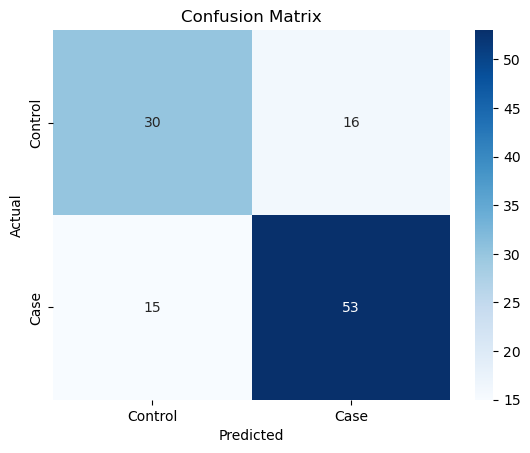

In [23]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'Case'], yticklabels=['Control', 'Case'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [24]:
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Specificity: {specificity}")
print(f"Sensitivity: {sensitivity}")

Accuracy: 0.7280701754385965
F1 Score: 0.7737226277372263
Specificity: 0.6521739130434783
Sensitivity: 0.7794117647058824


## Deep Autoencoder with Optimized Hyperparameters (Bayesian Optimization) - L1 Feature Selection

In [25]:
def create_deep_autoencoder(input_dim, neurons1=64, neurons2=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons1, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons1, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))  # Final classification layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [26]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

In [27]:
space = {
    'neurons1': scope.int(hp.quniform('neurons1', 32, 256, 32)),
    'neurons2': scope.int(hp.quniform('neurons2', 16, 128, 16)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'epochs': scope.int(hp.quniform('epochs', 50, 200, 50)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [32]:
def objective(params):
    model = KerasClassifier(
        model=create_deep_autoencoder,
        input_dim=X_final.shape[1],
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_final, y, cv=kfold, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)  # True Positive Rate / Recall
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Sensitivity: {sensitivity}, Specificity: {specificity}")

    # Return the negative F1 score as Hyperopt minimizes the objective function
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy, 'f1': f1, 'sensitivity': sensitivity, 'specificity': specificity}

In [33]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of evaluations to perform
            trials=trials)

print("Best parameters found: ", best)

  0%|                                                                           | 0/20 [00:00<?, ?trial/s, best loss=?]WARNING:tensorflow:5 out of the last 23 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000017C458277E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Accuracy: 0.6102292768959435, F1 Score: 0.7456846950517837, Sensitivity: 0.9671641791044776, Specificity: 0.09482758620689655
Accuracy: 0.6790123456790124

In [34]:
best_trial = min(trials.results, key=lambda x: x['loss'])
print(f"Best Accuracy: {best_trial['accuracy']}")
print(f"Best F1 Score: {-best_trial['loss']}")
print(f"Best Specificity: {best_trial['specificity']}")
print(f"Best Sensitivity: {best_trial['sensitivity']}")

Best Accuracy: 0.8395061728395061
Best F1 Score: 0.8627450980392157
Best Specificity: 0.8189655172413793
Best Sensitivity: 0.8537313432835821


In [36]:
best_params = {
    'neurons1': int(best['neurons1']),
    'neurons2': int(best['neurons2']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

best_model = create_deep_autoencoder(
    input_dim=X_final.shape[1],
    neurons1=best_params['neurons1'],
    neurons2=best_params['neurons2'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model.summary()

Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_507 (Dense)                    │ (None, 224)                 │          45,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_202 (Dropout)                │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_508 (Dense)                    │ (None, 48)                  │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_203 (Dropout)                │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_509 (Dense)                    │ (None, 224)                 │          10,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_510 (Dense)                    │ (None, 200)                 │          45,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_511 (Dense)                    │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 112,001 (437.50 KB)

 Trainable params: 112,001 (437.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\nBest Hyperparameters:")
print(f"Neurons in first layer: {int(best['neurons1'])}")
print(f"Neurons in second layer: {int(best['neurons2'])}")
print(f"Dropout rate: {best['dropout_rate']}")
print(f"Learning rate: {best['learning_rate']}")
print(f"Number of epochs: {int(best['epochs'])}")
print(f"Batch size: {int(best['batch_size'])}")

## Bidirectional LSTM with Bayesian Optimization - L1 Feature Selection

In [37]:
def create_rnn_model(input_shape, units=64, bidirectional=False, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    if bidirectional:
        model.add(Bidirectional(LSTM(units, return_sequences=False)))
    else:
        model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [38]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

In [39]:
space = {
    'units': scope.int(hp.quniform('units', 64, 256, 64)),  # Reduced range for faster evaluation
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.7),  # Reduced range
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),  # Adjusted range
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),  # Reduced number of epochs
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16)),  # Reduced range
    'bidirectional': hp.choice('bidirectional', [True, False])
}

In [42]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)  
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = KerasClassifier(
            model=create_rnn_model,
            input_shape=(X_final.shape[1], 1),
            units=params['units'],
            bidirectional=params['bidirectional'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=0
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred = model.predict(X_val)
        
        # Convert predictions to binary using a threshold of 0.5
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)  # True Positive Rate / Recall
        specificity = tn / (tn + fp)  # True Negative Rate

        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [43]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials
            trials=trials)

Iteration Results - Accuracy: 0.6931567328918322, F1 Score: 0.7477108978708281, Sensitivity: 0.7685469063221199, Specificity: 0.5831767131401494
Iteration Results - Accuracy: 0.7196467991169978, F1 Score: 0.7595704137872813, Sensitivity: 0.7530850679529149, Specificity: 0.6691156369600875
Iteration Results - Accuracy: 0.7350993377483444, F1 Score: 0.7697578237669638, Sensitivity: 0.7496340780920402, Specificity: 0.7123371149990887
Iteration Results - Accuracy: 0.6799116997792495, F1 Score: 0.7325588624874976, Sensitivity: 0.7419852807678557, Specificity: 0.5885530572261709
Iteration Results - Accuracy: 0.7064017660044151, F1 Score: 0.7311080756259365, Sensitivity: 0.6791777332307629, Specificity: 0.7452900036449791
Iteration Results - Accuracy: 0.6754966887417219, F1 Score: 0.7380611066885576, Sensitivity: 0.7727447137854293, Specificity: 0.5366804492436669
Iteration Results - Accuracy: 0.6953642384105959, F1 Score: 0.7487360682749312, Sensitivity: 0.7681664785584735, Specificity: 0.58

In [45]:
best_params = {
    'units': int(best['units']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size']),
    'bidirectional': best['bidirectional']
}

print("Best Hyperparameters:", best_params)

# Build and summarize the best model
best_model = create_rnn_model(
    input_shape=(X_final.shape[1], 1),
    units=best_params['units'],
    bidirectional=best_params['bidirectional'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])


Best Hyperparameters: {'units': 128, 'dropout_rate': 0.4134380442350706, 'learning_rate': 0.009180535567439925, 'epochs': 50, 'batch_size': 48, 'bidirectional': 0}


In [46]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step

Test Performance:
Accuracy: 0.7368421052631579
F1 Score: 0.7540983606557377
Sensitivity: 0.6865671641791045
Specificity: 0.8085106382978723


## GRU with Bayesian Optimization - L1 Feature Selection

In [17]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [49]:
def create_gru_model(input_shape, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [19]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [20]:
space = {
    'units': scope.int(hp.quniform('units', 64, 128, 64)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 20, 30, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [23]:
def objective(params):
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]
        
        model = KerasClassifier(
            model=create_gru_model,
            input_shape=(X_final.shape[1], 1),
            units=params['units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=0
        )
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        
        model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])
        
        y_val_pred = model.predict(X_val)
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)
    
    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")
    
    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [24]:
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

Iteration Results - Accuracy: 0.6333333333333333, F1 Score: 0.6539624183006536, Sensitivity: 0.7574548907882241, Specificity: 0.5292929292929293
Iteration Results - Accuracy: 0.6000000000000001, F1 Score: 0.6280188114659466, Sensitivity: 0.7535612535612536, Specificity: 0.4666666666666666
Iteration Results - Accuracy: 0.5944444444444444, F1 Score: 0.6061506776877904, Sensitivity: 0.687369420702754, Specificity: 0.5202020202020202
Iteration Results - Accuracy: 0.6, F1 Score: 0.6220538720538721, Sensitivity: 0.7301044634377968, Specificity: 0.4875816993464052
Iteration Results - Accuracy: 0.6611111111111111, F1 Score: 0.6537308482273846, Sensitivity: 0.7034188034188035, Specificity: 0.6191919191919192
Iteration Results - Accuracy: 0.6055555555555556, F1 Score: 0.625510058673011, Sensitivity: 0.7407407407407408, Specificity: 0.4875816993464052
Iteration Results - Accuracy: 0.5666666666666668, F1 Score: 0.5544767443732751, Sensitivity: 0.5978157644824311, Specificity: 0.5380867498514558
It

In [48]:
best_params = space_eval(space, best)  
print("Best Parameters:", best_params)  

Best Parameters: {'batch_size': 48, 'bidirectional': True, 'dropout_rate': 0.4134380442350706, 'epochs': 50, 'learning_rate': 0.009180535567439925, 'units': 128}


In [50]:
best_model = create_gru_model(
    input_shape=(X_final.shape[1], 1),
    units=best_params['units'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

In [51]:
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [52]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

In [53]:
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step

Test Performance:
Accuracy: 0.6666666666666666
F1 Score: 0.7432432432432432
Sensitivity: 0.8208955223880597
Specificity: 0.44680851063829785


## CNN with Bayesian Optimization - L1 Feature Selection

In [54]:
X_selected = X_final.reshape(X_final.shape[0], X_final.shape[1], 1)  # Add a channel dimension

In [55]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [56]:
def create_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [57]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 2, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [58]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = create_cnn_model(
            input_shape=(X_selected.shape[1], 1),
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred = model.predict(X_val)
        
        # Convert predictions to binary using a threshold of 0.5
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [59]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials, adjust based on your needs
            trials=trials)

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step                                               
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step                                               
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step                                                

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step                                               
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step                                               
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step                                                

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step                                               
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step                                               
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step                                                

Iteration Results - Accuracy: 0.6887417218543046, F1 Score: 0.7509219263944225, Sensitivity: 0.7989617919442481, Specificity: 0.5349206349206349
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step                                           

In [60]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.27017929251623335, 'epochs': 40, 'filters': 32, 'kernel_size': 4, 'learning_rate': 0.003915110105257093}


In [61]:
best_model = create_cnn_model(
    input_shape=(X_selected.shape[1], 1),
    filters=best_params['filters'],
    kernel_size=best_params['kernel_size'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

In [62]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

In [63]:
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [64]:
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")


Test Performance:
Accuracy: 0.7631578947368421
F1 Score: 0.7969924812030075
Sensitivity: 0.7794117647058824
Specificity: 0.7391304347826086


## ResNet - L1 Feature Selection

In [68]:
X_selected = X_final.reshape((X_final.shape[0], X_final.shape[1], 1))

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [70]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same', strides=stride)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, kernel_size, padding='same', strides=1)(x)
    x = BatchNormalization()(x)
    
    if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv1D(filters, kernel_size, padding='same', strides=stride)(shortcut)
        shortcut = BatchNormalization()(shortcut)
        
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

In [71]:
def create_resnet_model(input_shape, filters=64, num_blocks=6, kernel_size=3, dropout_rate=0.5, learning_rate=0.001):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters, kernel_size=kernel_size, padding='same', strides=1)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    for _ in range(num_blocks):
        x = residual_block(x, filters, kernel_size=kernel_size)
    
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [72]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'num_blocks': scope.int(hp.quniform('num_blocks', 4, 10, 2)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 3, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16)),
    'epochs': scope.int(hp.quniform('epochs', 20, 50, 10))
}

In [73]:
def objective(params):
    print(f"Trying params: {params}")
    filters = params['filters']
    num_blocks = params['num_blocks']
    kernel_size = params['kernel_size']
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']
    
    # Create the ResNet model
    model = create_resnet_model(input_shape=(X_train.shape[1], 1),
                                filters=filters,
                                num_blocks=num_blocks,
                                kernel_size=kernel_size,
                                dropout_rate=dropout_rate,
                                learning_rate=learning_rate)
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Filters: {filters}, Blocks: {num_blocks}, Kernel Size: {kernel_size}, Dropout: {dropout_rate}, LR: {learning_rate}, Batch Size: {batch_size}, Epochs: {epochs}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [74]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Adjust the number of evaluations
            trials=trials)

Trying params: {'batch_size': 16, 'dropout_rate': 0.23277877337170363, 'epochs': 30, 'filters': 128, 'kernel_size': 5, 'learning_rate': 0.005912816096082353, 'num_blocks': 10}
Iteration - Loss: 0.7519435286521912, Filters: 128, Blocks: 10, Kernel Size: 5, Dropout: 0.23277877337170363, LR: 0.005912816096082353, Batch Size: 16, Epochs: 30
Trying params: {'batch_size': 48, 'dropout_rate': 0.24289420750888183, 'epochs': 40, 'filters': 64, 'kernel_size': 4, 'learning_rate': 0.00977333118221983, 'num_blocks': 10}
Iteration - Loss: 0.6311425566673279, Filters: 64, Blocks: 10, Kernel Size: 4, Dropout: 0.24289420750888183, LR: 0.00977333118221983, Batch Size: 48, Epochs: 40
Trying params: {'batch_size': 32, 'dropout_rate': 0.32657696694726546, 'epochs': 40, 'filters': 64, 'kernel_size': 4, 'learning_rate': 0.00018336250117203753, 'num_blocks': 8}
Iteration - Loss: 0.6288678050041199, Filters: 64, Blocks: 8, Kernel Size: 4, Dropout: 0.32657696694726546, LR: 0.00018336250117203753, Batch Size: 32

In [75]:
best_params = space_eval(space, best)
print(f"Best parameters: {best_params}")

Best parameters: {'batch_size': 16, 'dropout_rate': 0.43659101558974983, 'epochs': 20, 'filters': 96, 'kernel_size': 4, 'learning_rate': 0.0007138423493773261, 'num_blocks': 6}


In [76]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
best_model = create_resnet_model(input_shape=(X_train.shape[1], 1),
                                 filters=best_params['filters'],
                                 num_blocks=best_params['num_blocks'],
                                 kernel_size=best_params['kernel_size'],
                                 dropout_rate=best_params['dropout_rate'],
                                 learning_rate=best_params['learning_rate'])

In [80]:
history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_split=0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.7066 - loss: 0.6163 - val_accuracy: 0.7826 - val_loss: 0.4449
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.6853 - loss: 0.5904 - val_accuracy: 0.6739 - val_loss: 0.5501
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.7181 - loss: 0.6043 - val_accuracy: 0.6304 - val_loss: 3.3590
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.7430 - loss: 0.4982 - val_accuracy: 0.8261 - val_loss: 0.4716


In [81]:
y_test_pred = (best_model.predict(X_test) > 0.5).astype("int32")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step 


In [82]:
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")


Test Performance:
Accuracy: 0.6842105263157895
F1 Score: 0.7631578947368421
Sensitivity: 0.8529411764705882
Specificity: 0.43478260869565216
